# Simple resnet layer implementation
Following the implicit layers tutorial

In [1]:
from solvers import broyden, anderson

In [2]:
def anderson_resnet(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)

        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [4]:
class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))

In [5]:
X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
out = anderson_resnet(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)

C:\Users\weipy\AppData\Local\Temp\ipykernel_31736\2317070265.py:19: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)


Text(0, 0.5, 'Relative residual')

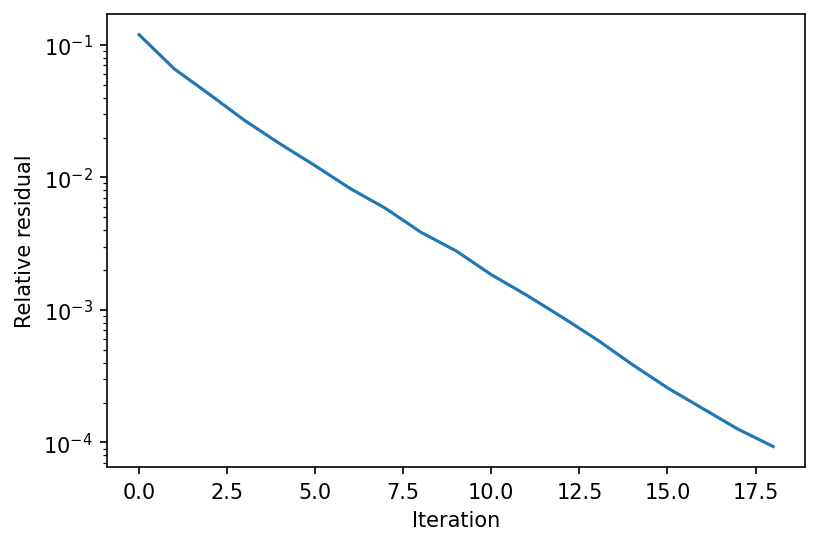

In [6]:
plt.figure(dpi=150)
plt.semilogy(out[1])
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

# DEQLAYER
Test implementation of deq bert by using gradcheck to make sure backward pass is computed correctly.

In [1]:
from solvers import broyden, anderson
import torch
import torch.nn as nn
import torch.autograd as autograd

from transformers.models.roberta.modeling_roberta import RobertaLayer, RobertaEmbeddings
from transformers.models.roberta.configuration_roberta import RobertaConfig
from transformers import RobertaTokenizer

import bertdeq

Initialise the weights with smaller values

In [2]:
def init_weights(module):
    """ Initialize the weights """
    if isinstance(module, (nn.Linear, nn.Embedding)):
        # Slightly different from the TF version which uses truncated_normal for initialization
        # cf https://github.com/pytorch/pytorch/pull/5617
        module.weight.data.normal_(0, 0.01)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.zero_()

In [3]:
x = torch.randn(1, 8, 768)
config = RobertaConfig(is_decoder=False, training=False)
layer = bertdeq.DEQRobertaLayer(config).double()
layer.apply(init_weights)
layer.layer = layer.layer.double()
layer

DEQRobertaLayer(
  (layer): RobertaLayer(
    (attention): RobertaAttention(
      (self): RobertaSelfAttention(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): RobertaSelfOutput(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): RobertaIntermediate(
      (dense): Linear(in_features=768, out_features=3072, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): RobertaOutput(
      (dense): Linear(in_features=3072, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)

Is gradcheck supposed to take so long?

In [4]:
from torch.autograd import gradcheck

# (batch size, seq_len, hidden_size)
input_tensor = torch.randn((1, 2, 768)).double().requires_grad_()

gradcheck(layer, input_tensor, eps=1e-5, atol=1e-3, check_undefined_grad=False)

True

# Testing full RobertaModel

In [1]:
import torch
from transformers import RobertaConfig, RobertaTokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
encoded = tokenizer("What the dog doing", return_tensors='pt')
encoded

In [2]:
inputs = {'input_ids': torch.tensor([[   0, 2264,    5, 2335,  608,    2]]), 'attention_mask': torch.tensor([[1, 1, 1, 1, 1, 1]])}
inputs

{'input_ids': tensor([[   0, 2264,    5, 2335,  608,    2]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [3]:
config = RobertaConfig(is_decoder=False, training=False)
model = bertdeq.RobertaModel(config)
model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768, padding_idx=1)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): DEQRobertaLayer(
      (layer): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropo

In [4]:
outputs = model(**inputs)
outputs

self.training True
DEQ RobertaLayer forward pass hidden_states of shape torch.Size([1, 6, 768]): tensor([[[ 0.0354, -0.2224, -1.1875,  ..., -0.9804,  0.1060,  0.4998],
         [-0.4524,  0.5653, -0.5649,  ...,  0.7681,  1.1572,  1.5648],
         [ 1.1318,  0.8248,  0.3080,  ...,  0.0000, -0.5638,  0.1203],
         [-0.8171,  0.7475,  0.0000,  ..., -1.1498, -1.0701,  0.8929],
         [ 0.4312,  0.0000, -0.3536,  ...,  0.5847,  0.1117,  0.8905],
         [-1.6665, -0.6823, -1.4122,  ...,  1.2832, -1.0861,  2.0074]]],
       grad_fn=<MulBackward0>)
DEQRobertaLayer forward pass output: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<NativeLayerNormBackward0>)
RobertaEncoder layer outputs: (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [

C:\Users\weipy\OneDrive\Documents\GitHub\implicit-bert\BertDEQ\solvers.py:224: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:859.)
  alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

In [14]:
x = outputs['last_hidden_state'].detach()
x

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [15]:
x.max()

tensor(0.)